1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting


# Pre-requistes

In [205]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [206]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [207]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [208]:
PATH = "/home/paperspace/data/seeds/"

In [209]:
!date

Tue Jan 23 01:53:12 EST 2018


## Get data

### Directory based structure

In [210]:
!ls {PATH}

models	sample_submission.csv.zip  test  tmp  train  valid


In [211]:
!ls {PATH}valid

Black-grass  Common Chickweed  Loose Silky-bent   Shepherds Purse
Charlock     Common wheat      Maize		  Small-flowered Cranesbill
Cleavers     Fat Hen	       Scentless Mayweed  Sugar beet


In [212]:
# MAX size
files = !ls -S {PATH}valid/Maize | head
files

['f98add892.png',
 'a1d7080b1.png',
 '8caddf555.png',
 'c9b1820d0.png',
 '030e7f9ef.png',
 '65ba0f497.png',
 'a53a61390.png',
 '4e04b01b7.png',
 'c621da984.png',
 '5c7abc049.png']

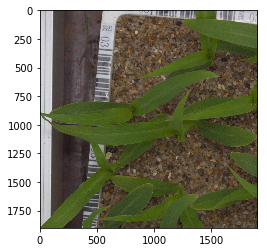

In [213]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [214]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(1900, 1900, 3)

In [215]:
# MIN size
files = !ls -rS {PATH}valid/Maize | head
files

['16e38d4af.png',
 '988113525.png',
 '5363a9f84.png',
 'af014d45e.png',
 '01642cae8.png',
 '5885bb41b.png',
 '59f972ef4.png',
 '798852825.png',
 'fdebe4158.png',
 'bb9f796ce.png']

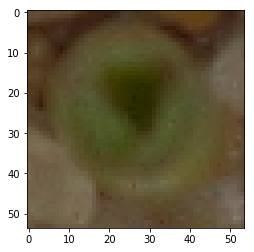

In [216]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [217]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(54, 54, 3)

In [218]:
def get_tfms(f_model, size): return tfms_from_model(f_model, size)

In [219]:
def get_aug_tfms(f_model, size): return tfms_from_model(f_model, size, aug_tfms=transforms_side_on, max_zoom=1.1)

In [220]:
def get_data_from_csv(f_model, sz, tfms):
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [221]:
def get_data_from_dir(f_mode, sz, tfms):
    return ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name='test')

# Enable data augmentation, and precompute=True

## Initial model setup

In [287]:
arch=resnet34
size=256

In [288]:
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size))

In [ ]:
learn.freeze
learn = ConvLearner.pretrained(arch, data, precompute=False)

# Use lr_find() to find highest learning rate where loss is still clearly improving

In [ ]:
discovered_learning_rate = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 76%|███████▌  | 57/75 [00:27<00:08,  2.11it/s, loss=2.24]

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [ ]:
learning_rate = 0.1

# Train last layer from precomputed activations for 1-2 epochs

In [ ]:
learn.fit(learning_rate, 3)

## Analyse output - TBD

# Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1

In [ ]:
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size))

In [ ]:
#learn = ConvLearner.pretrained(arch, data, precompute=False)

In [ ]:
learn.fit(learning_rate, 3, cycle_len=1)

In [ ]:
learn.save(f'seeds_last_layer_{size}')

# Train full network with cycle_mult=2 until over-fitting

### Unfreeze all layers

In [ ]:
learn.unfreeze()

### Find learning rate again

In [ ]:
#learn = ConvLearner.pretrained(arch, data, precompute=False)

In [ ]:
new_learning_rate = learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

### Set earlier layers to 3x-10x lower learning rate than next higher layer

In [ ]:
new_learning_rate = 0.03
#new_learning_rate = 0.007

#new_learning_rate = 0.005
#learning_rates = np.array([new_learning_rate/9, new_learning_rate/3, new_learning_rate])

learning_rates = np.array([3e-4, 3e-3, new_learning_rate])
#learning_rates = np.array([7e-5, 7e-4, new_learning_rate])
#learning_rates = np.array([new_learning_rate/9, new_learning_rate/3, new_learning_rate])

### Train entire network

In [ ]:
learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save(f'seeds_entire_network_{size}')

# Check accuracy

## Validation set

In [ ]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy(probs, y)

## Test set

In [ ]:
learn.data.classes

In [ ]:
test_log_preds, test_y = learn.TTA(is_test=True)
test_probs = np.mean(np.exp(test_log_preds), 0)
print(accuracy(test_probs, test_y))

In [ ]:
print(test_probs.shape)
print(test_probs[:4])
print(test_probs[0, 0])

In [ ]:
class_indexes = np.argmax(test_probs, axis=1)

In [ ]:
learn.data.classes[class_indexes[0]]

# Submit to kaggle (optional)

In [ ]:
test_classes = [learn.data.classes[i] for i in class_indexes]
print(len(test_classes))
print(test_classes[:5])


In [ ]:
test_dl = learn.data.test_dl
test_filenames = test_dl.dataset.fnames
print(len(test_filenames))
print(test_filenames[:5])

In [ ]:
fileIds = np.array([f[5:] for f in test_filenames])
fileIds[:5]

In [ ]:
submission = np.stack([fileIds,test_classes], axis=1)
submission[:5]

In [ ]:
!pwd

In [ ]:
now = datetime.datetime.now()
submission_file_name = f'plant-seed-submission-{str(now)}.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, submission, fmt='%s,%s', header='file,species', comments='')

In [ ]:
from IPython.display import FileLink
FileLink(submission_file_name)

In [ ]:
!date